In [1]:
import torch
import pandas as pd
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import os

# 定义 CNN 模型（与训练时相同的结构）
class CNNRegressor(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CNNRegressor, self).__init__()
        
        # 卷积层
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # 池化层
        self.pool = nn.MaxPool2d(2, 2)
        
        # Dropout 层
        self.dropout = nn.Dropout(p=dropout_rate)  # 设置 dropout 比率
        
        # 全连接层
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # 假设输入图片尺寸为 128x128
        self.fc2 = nn.Linear(512, 1)  # 输出一个性能指标值
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        
        # Dropout 层
        x = self.dropout(x)
        
        # 展平
        x = x.view(x.size(0), -1)
        
        # 全连接层
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 自定义数据集，用于读取图片并进行预处理
class ImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_names = [f"{i}.png" for i in range(1, 1101)]  # 假设图片命名为 1.png, 2.png, ..., 1100.png
        self.transform = transform
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_folder, img_name)
        img = Image.open(img_path).convert("RGB")  # 确保图片是 RGB 模式
        
        if self.transform:
            img = self.transform(img)
        
        return img, img_name  # 返回图片和图片名称

# 数据预处理
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 将图片调整为 128x128
    transforms.ToTensor(),          # 转换为张量
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 归一化
])

# 加载 CTE 和 Permittivity 模型
model_path_cte = r'E:\daore1\CTE_best_model_r2.pth'  # CTE 模型路径
model_path_permittivity = r'E:\daore1\permittivity_best_model_r2.pth'  # Permittivity 模型路径

# 初始化模型
model_cte = CNNRegressor(dropout_rate=0.5).cuda()  # 使用相同的 dropout 比率
model_permittivity = CNNRegressor(dropout_rate=0.5).cuda()

# 加载模型参数
model_cte.load_state_dict(torch.load(model_path_cte))  
model_permittivity.load_state_dict(torch.load(model_path_permittivity))

# 设置模型为评估模式，禁用 Dropout
model_cte.eval()
model_permittivity.eval()

# 图片文件夹路径
image_folder = r'E:\daore1'  # 图片文件夹路径

# 创建数据集和数据加载器
dataset = ImageDataset(image_folder=image_folder, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# 用来存储预测结果
predictions_cte = []
predictions_permittivity = []

# 进行预测
with torch.no_grad():
    for inputs, image_names in data_loader:
        inputs = inputs.cuda()  # 如果有 GPU，使用 CUDA 加速
        
        # CTE 性能指标预测
        outputs_cte = model_cte(inputs)  # 获取 CTE 预测结果
        
        # Permittivity 性能指标预测
        outputs_permittivity = model_permittivity(inputs)  # 获取 Permittivity 预测结果
        
        # 将预测结果存储到列表中
        predictions_cte.extend(zip(image_names, outputs_cte.cpu().numpy().flatten()))
        predictions_permittivity.extend(zip(image_names, outputs_permittivity.cpu().numpy().flatten()))

# 将预测结果保存到列表，格式为 (图片名称, CTE预测值, Permittivity预测值)
predictions_list = []
for cte, permittivity in zip(predictions_cte, predictions_permittivity):
    predictions_list.append((cte[0], cte[1], permittivity[1]))

# 将预测结果保存到 DataFrame 中
predictions_df = pd.DataFrame(predictions_list, columns=["Image_Name", "CTE_Predicted", "Permittivity_Predicted"])

# 将预测结果保存为 Excel 文件
predictions_df.to_excel(r'E:\daore1\predictions.xlsx', index=False)

# 打印前 10 条预测结果
print(predictions_list[:10])  # 打印前 10 条预测结果



D:\anaconda3\lib\site-packages\torch\nn\modules\module.py:911: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/cuda/CUDAAllocatorConfig.h:30.)
  return self._apply(lambda t: t.cuda(device))


[('1.png', 32.61713, 2.1936576), ('2.png', 33.49537, 2.1394072), ('3.png', 50.230286, 2.0763676), ('4.png', 49.963753, 2.0424066), ('5.png', 49.86271, 2.0825315), ('6.png', 47.20125, 2.0546196), ('7.png', 48.36526, 2.0786018), ('8.png', 47.883305, 2.0432792), ('9.png', 47.715355, 2.091753), ('10.png', 48.340405, 2.0911846)]


请输入介电常数的筛选值（例如：2.3）：2.3
请输入热膨胀系数的筛选值（例如：60）：60
筛选出的 11 张图片：
图片名称: 1.png, 介电常数: 2.193657636642456, 热膨胀系数: 32.61713027954102
图片名称: 61.png, 介电常数: 2.229604721069336, 热膨胀系数: 33.38972473144531
图片名称: 2.png, 介电常数: 2.139407157897949, 热膨胀系数: 33.49536895751953
图片名称: 170.png, 介电常数: 2.241094589233398, 热膨胀系数: 34.44728088378906
图片名称: 172.png, 介电常数: 2.249811172485352, 热膨胀系数: 35.35971832275391
图片名称: 410.png, 介电常数: 2.287162303924561, 热膨胀系数: 36.1598014831543
图片名称: 404.png, 介电常数: 2.251941442489624, 热膨胀系数: 36.36422729492188
图片名称: 373.png, 介电常数: 2.289524078369141, 热膨胀系数: 36.55131530761719
图片名称: 359.png, 介电常数: 2.286809921264648, 热膨胀系数: 36.74362945556641
图片名称: 463.png, 介电常数: 2.216232538223267, 热膨胀系数: 37.05777740478516
图片名称: 283.png, 介电常数: 2.287837505340576, 热膨胀系数: 37.16025161743164


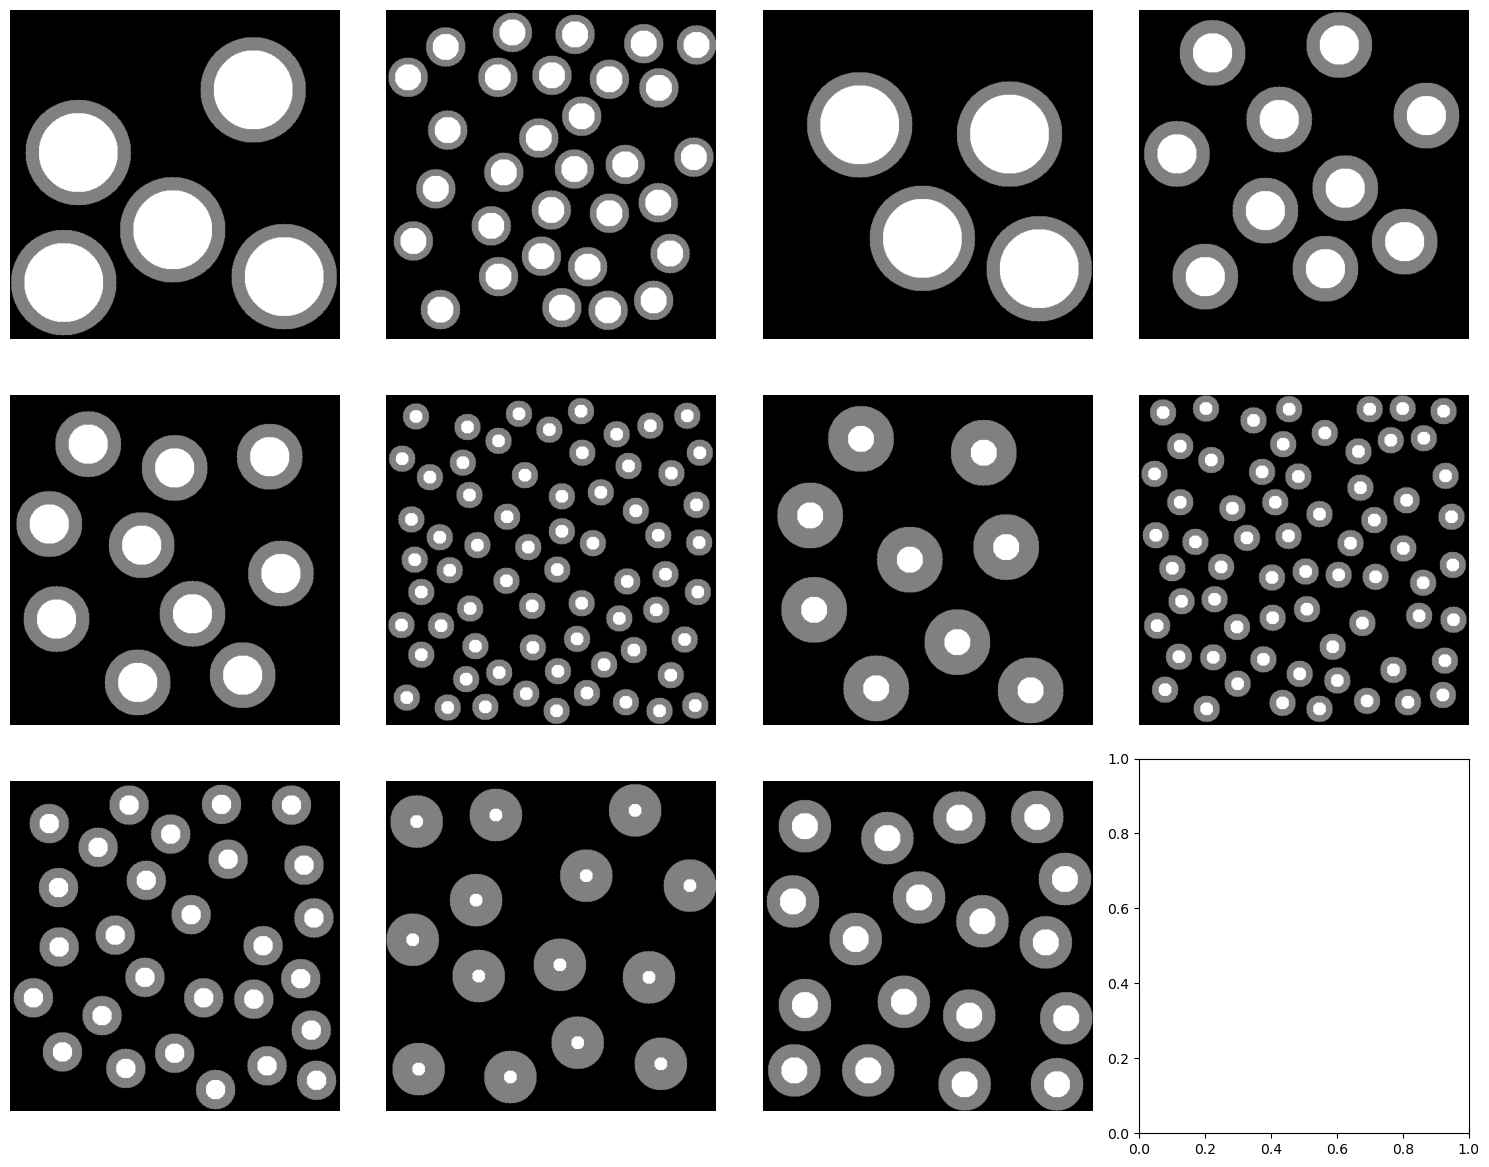

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 设置图片目录和Excel文件路径
image_dir = r'E:\daore1'
excel_file = r'E:\daore1\predictions.xlsx'

# 读取Excel文件
df = pd.read_excel(excel_file)

# 确保列名与Excel中一致，这里假设Excel文件的列名分别是'图片名称', '热膨胀系数', '介电常数'
df.columns = ['Image_Name', 'CTE_Predicted', 'Permittivity_Predicted']

# 获取用户输入的筛选条件
try:
    dielectric_threshold = float(input("请输入介电常数的筛选值（例如：2.3）："))
    thermal_expansion_threshold = float(input("请输入热膨胀系数的筛选值（例如：60）："))
except ValueError:
    print("输入无效，请输入数字。")
    exit(1)

# 按照介电常数和热膨胀系数的条件进行筛选
filtered_df = df[(df['Permittivity_Predicted'] < dielectric_threshold) & (df['CTE_Predicted'] < thermal_expansion_threshold)]

# 如果没有符合条件的图片，输出提示
if filtered_df.empty:
    print("没有符合筛选条件的图片。")
    exit(0)

lowest_11_images = filtered_df.sort_values(by=['CTE_Predicted','Permittivity_Predicted']).head(11)

# 输出这 11 张图片的信息
print("筛选出的 11 张图片：")
for i, row in lowest_11_images.iterrows():
    print(f"图片名称: {row['Image_Name']}, 介电常数: {row['Permittivity_Predicted']}, 热膨胀系数: {row['CTE_Predicted']}")

# 显示这 11 张图片
fig, axes = plt.subplots(3, 4, figsize=(15, 12))  # 创建一个 3x4 的图像展示窗口（最多显示 12 张图片）
axes = axes.flatten()

for i, (index, row) in enumerate(lowest_11_images.iterrows()):
    image_name = row['Image_Name']
    image_path = os.path.join(image_dir, image_name)
    img = mpimg.imread(image_path)
    
    # 显示图片
    axes[i].imshow(img)
    axes[i].axis('off')  # 不显示坐标轴
    
    # 获取性能指标
    thermal_expansion = row['CTE_Predicted']
    dielectric_constant = row['Permittivity_Predicted']
    


# 调整布局并展示图片
plt.tight_layout()
plt.show()